In [5]:
#IMPORT LIBRARIES
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
import string
import preprocessor as p
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot
from wordcloud import WordCloud
from PIL import Image

In [6]:
#CONNECT TO MONGODB
client = MongoClient("mongodb://localhost:27017")
db = client["twitter"]
collection = db["tweets"]

In [7]:
#EXTRACTING TWEETS
sw = stopwords.words('english')
sp = string.punctuation
list_tweets = []
for data1 in  collection.aggregate([ { "$project" : { "_id" : 0 , "text" : 1 } } ]):
    list_tweets.append(data1)
    
df1 = pd.DataFrame(list_tweets)

In [8]:
#MOST USED HASHTAGS
hashs = dict()
for data2 in df1['text']:
    words = re.findall("#(\w+)",data2)
    for word in words:
        if word in hashs:
            hashs[word] += 1
        else:
            hashs[word] = 1
 
df5 = pd.DataFrame(hashs.items(), columns=['hashtag', 'number of iterations']).sort_values(by ='number of iterations' , ascending=False)
df5 = df5.reset_index(drop=True)
df6 = df5.head(10)
df6

,hashtag,number of iterations
0,OTD,282
1,UCL,60
2,ACMilan,39
3,UEL,29
4,rmalive,29
5,RealMadrid,25
6,FootballShirtFriday,23
7,EuroLeague,14
8,HalaMadrid,13
9,JuveBarca,11


In [9]:
#CLEANING TWEETS
clean_tweets = df1['text']
for i in range(clean_tweets.size):
    clean_tweets[i] = p.clean(clean_tweets[i])
    clean_tweets[i] = re.sub("["+sp+"]","",clean_tweets[i])

In [10]:
#MOST USED WORDS
most_used_words = dict()
for data2 in clean_tweets:
    words = data2.lower().split()
    for word in words:
        if word in most_used_words and word not in sw :
            most_used_words[word] += 1
        else:
            most_used_words[word] = 1
            
df2 = pd.DataFrame(most_used_words.items(), columns=['word', 'value']).sort_values(by ='value' , ascending=False)
df2 = df2.reset_index(drop=True)
df22 = df2.head(10)
df22

,word,value
0,real,8267
1,madrid,6816
2,vs,2158
3,benzema,1666
4,vinicius,1582
5,jr,1462
6,madrids,1369
7,karim,1303
8,gladbach,1293
9,pass,1236


In [11]:
#SENTIMENT ANALYSIS
pos,neg,neu = 0,0,0
df_sentiment = pd.DataFrame(columns=["Tweet","Sentiment"])

for tweet in clean_tweets:
    tweet_analysis = TextBlob(tweet)
    if tweet_analysis.polarity > 0:
        df_sentiment = df_sentiment.append({"Tweet" : tweet , "Sentiment" : "Positif"}, ignore_index=True)
        pos += 1
    elif tweet_analysis.polarity == 0:
        df_sentiment = df_sentiment.append({"Tweet" : tweet , "Sentiment" : "Neutral"}, ignore_index=True)
        neu+= 1
    else:
        df_sentiment = df_sentiment.append({"Tweet" : tweet , "Sentiment" : "Negatif"}, ignore_index=True)
        neg += 1

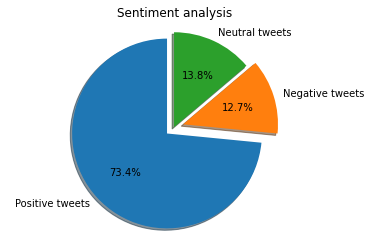

In [12]:
labels = 'Positive tweets', 'Negative tweets', 'Neutral tweets'
val = [ pos , neg , neu]
explode = (0.1, 0.1, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(val, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title("Sentiment analysis")
plt.show()

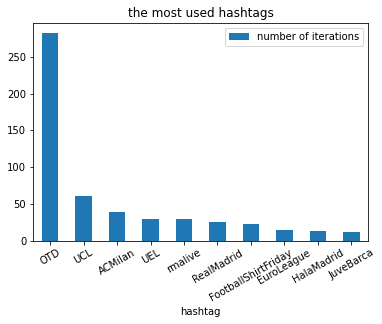

In [13]:
#BAR PLOT OF THE MOST 10 MOST USED HASHTAGS
df6.plot(kind='bar',x="hashtag" ,y="number of iterations", rot=30 , title="the most used hashtags")

<function matplotlib.pyplot.show(*args, **kw)>

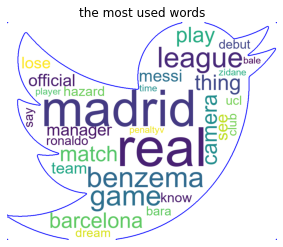

In [14]:
#WORD CLOUD
mask = np.array(Image.open(r"C:\Users\AYOUB\Desktop\twitter_mask.png"))

comment_words = ''
for i in df2['word']:
    comment_words += " "+i+" "
    
wc = WordCloud(font_path='arial', background_color='white', mask = mask,contour_width=3, 
               contour_color='blue',
                  mode='RGB', width=3000, height=1500 ,max_words=30).generate(comment_words)

plt.title("the most used words")
plt.imshow(wc)
plt.axis("off")
plt.show